In [3]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
torch.cuda.set_device(1)

__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(25)
        self.fc = nn.Linear(512 * block.expansion, num_classes, bias=False)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

def uniform(stdev, size):
    return np.random.uniform(
                low=-stdev * np.sqrt(3),
                high=stdev * np.sqrt(3),
                size=size
            ).astype('float32')

def initialize_linear(m):
    weight_values = uniform(
                np.sqrt(2./(m.in_features+m.out_features)),
                (m.in_features, m.out_features)
            )
    return weight_values

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        weight_values = torch.from_numpy(initialize_linear(m))
        m.weight.data.copy_(weight_values,broadcast=False)

def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model_dict = model.state_dict()
        pretrained_dict = model_zoo.load_url(model_urls['resnet18'])
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
        pretrained_dict.pop(u'fc.weight')
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)
        weights_init(model)
    return model


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model_dict = model.state_dict()
        pretrained_dict = model_zoo.load_url(model_urls['resnet34'])
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
        pretrained_dict.pop(u'fc.bias')
        pretrained_dict.pop(u'fc.weight')
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model_dict = model.state_dict()
        pretrained_dict = model_zoo.load_url(model_urls['resnet50'])
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
        pretrained_dict.pop(u'fc.bias')
        pretrained_dict.pop(u'fc.weight')
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)
    return model


def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model_dict = model.state_dict()
        pretrained_dict = model_zoo.load_url(model_urls['resnet101'])
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
        pretrained_dict.pop(u'fc.bias')
        pretrained_dict.pop(u'fc.weight')
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)
    return model


def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model_dict = model.state_dict()
        pretrained_dict = model_zoo.load_url(model_urls['resnet152'])
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
        pretrained_dict.pop(u'fc.bias')
        pretrained_dict.pop(u'fc.weight')
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)
    return model


In [14]:
from torch.autograd import Variable
import torch
import torchvision
from torchvision import transforms
import os 

batchsize = 32

label_0 = len(os.listdir('/disk2/dataset_0724_for_pytorch/0/'))
label_1 = len(os.listdir('/disk2/dataset_0724_for_pytorch/1/'))

class_sample_count = [label_0, label_1]
weights = 1 / torch.DoubleTensor(class_sample_count)
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, batchsize)

dataset = torchvision.datasets.ImageFolder('/disk2/dataset_0724_for_pytorch/',
                                           transforms.Compose([
                                               transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(dataset, shuffle=False
                                           , sampler = sampler 
                                           , batch_size=batchsize
                                           , num_workers=4)

#train_iter = iter(train_loader)

val_dataset = torchvision.datasets.ImageFolder('/disk2/dataset_0724_test_for_pytorch/',
                                           transforms.Compose([
                                               transforms.ToTensor()]))
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=False, batch_size=1, num_workers=4)
#val_iter = iter(val_loader)

model = resnet18(num_classes=2,pretrained=True).cuda()

In [18]:
optimizer = torch.optim.Adam(model.parameters(), 0.001)

criterion = nn.CrossEntropyLoss()
criterion = criterion.cuda()

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = 0.1 * (0.1 ** (epoch // 20))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def train(train_loader, model, criterion, optimizer, epoch):
    """Train for one epoch on the training set"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()
    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        adjust_learning_rate(optimizer, epoch)
        target_var = Variable(target.cuda())
        input_var = Variable(input.cuda())

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target_var, topk=(1,))[0]
        losses.update(loss.data[0], input.size(0))
        top1.update(prec1[0], input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 5 == 0:
            
            with open("classification.txt","a") as f:
                f.write('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      loss=losses, top1=top1) + '\n')
                f.close()
                
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      loss=losses, top1=top1))
    # log to TensorBoard
        model.zero_grad()

def validate(val_loader, model, criterion, epoch):
    """Perform validation on the validation set"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        target_var = Variable(target.cuda())
        input_var = Variable(input.cuda())

        # compute output
        output = model(input_var)
     #   print (output)
        loss = criterion(output, target_var)

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target_var, topk=(1,))[0]
        losses.update(loss.data[0], input.size(0))
        top1.update(prec1[0], input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

       # if i % 50 == 0:
       #     print('Test: [{0}/{1}]\t'
       #           'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
       #           'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
       #           'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
       #               i, len(val_loader), batch_time=batch_time, loss=losses,
       #               top1=top1))
    with open("classification.txt","a") as f:
            f.write(' * Prec@1 {top1.avg:.3f}'.format(top1=top1) + '\n')
            f.close()
    print(' * Prec@1 {top1.avg:.3f}'.format(top1=top1))
    # log to TensorBoard
  #  if args.tensorboard:
  #      log_value('val_loss', losses.avg, epoch)
  #      log_value('val_acc', top1.avg, epoch)
    return top1.avg

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.data.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

import time
for j in range(0,50000):
    train(train_loader, model, criterion, optimizer, j)
    if j%1 == 0 :
        prec1 = validate(val_loader, model, criterion, j)
        #torch.save(model.state_dict(), '/home/hubo/notebook/20170307/new_lesion_epoch_%d_%.1f.pth' % (j,prec1))
        #torch.save(m.state_dict(), '/home/hubo/notebook/20170307/new_lesion_m_epoch_%d_%.1f.pth' % (j,prec1))

Epoch: [0][0/1]	Time 7.178 (7.178)	Loss 0.3461 (0.3461)	Prec@1 100.000 (100.000)
 * Prec@1 17.012
Epoch: [1][0/1]	Time 4.270 (4.270)	Loss 0.0000 (0.0000)	Prec@1 100.000 (100.000)
 * Prec@1 17.012
Epoch: [2][0/1]	Time 3.607 (3.607)	Loss 0.0000 (0.0000)	Prec@1 100.000 (100.000)
 * Prec@1 17.012
Epoch: [3][0/1]	Time 3.742 (3.742)	Loss 0.0000 (0.0000)	Prec@1 100.000 (100.000)
 * Prec@1 17.012
Epoch: [4][0/1]	Time 3.936 (3.936)	Loss 0.0000 (0.0000)	Prec@1 100.000 (100.000)


In [ ]:
class generate_heatmap(nn.Module):

    def __init__(self, block, layers, num_classes=2):
        self.inplanes = 64
        super(generate_heatmap, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        #self.avgpool = nn.AvgPool2d(25)
        #self.fc = nn.Linear(512 * block.expansion, num_classes, bias=False)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        return x

heatmap_model = generate_heatmap(BasicBlock, [2, 2, 2, 2])
model_dict = heatmap_model.state_dict()
pretrained_dict = model.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
#linear_weight = pretrained_dict.pop(u'fc.weight')
model_dict.update(pretrained_dict)
heatmap_model.load_state_dict(model_dict)

val_iter = iter(val_loader)
#for img,label in val_iter:
   # if int(img_label.numpy())==1:
        #break

In [ ]:
val_iter = iter(val_loader)
img,label = val_iter.next()

In [86]:
img,label = val_iter.next()
print(model(Variable(img.cuda())))
print(label)

Variable containing:
 0.9435 -0.7827
[torch.cuda.FloatTensor of size 1x2 (GPU 0)]


 1
[torch.LongTensor of size 1]




 1
[torch.LongTensor of size 1]



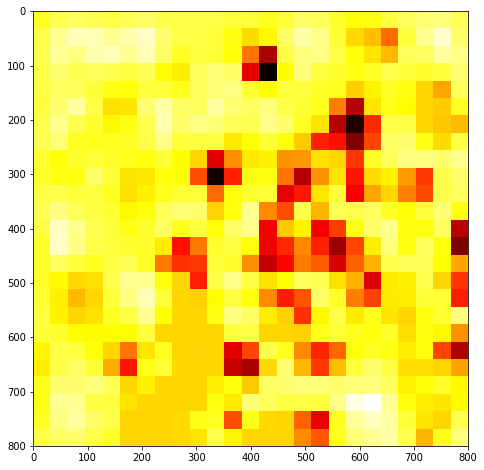

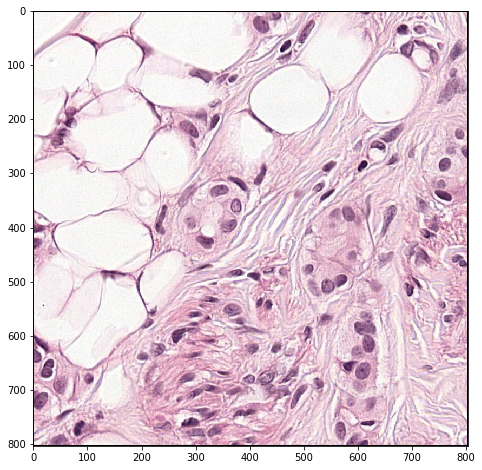

In [88]:
import torchvision.utils as vutils
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

img,label = val_iter.next()
print(label)
heatmap_model = heatmap_model.cuda()
heatmap = heatmap_model(Variable(img.cuda()))
heat = torch.mm(linear_weight, heatmap.data.view(512,-1)).view(1,2,25,25)
heat = torch.nn.functional.upsample(Variable(heat), size=800).data
vutils.save_image(img, 'img.png',normalize=True)
plt.rcParams['figure.figsize'] = 8, 8

plt.imshow(heat.cpu().numpy()[0,0], cmap='hot', interpolation='nearest')
plt.show()
plt.imshow(mpimg.imread("img.png"))
plt.show()


In [72]:
heatmap

Variable containing:
( 0 , 0 ,.,.) = 
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000
   0.0000   0.0000   0.0000  ...    0.0569   0.0777   0.0000
   0.0000   0.0000   0.0000  ...    0.0512   0.0818   0.0000
            ...               ⋱              ...            
   0.0000   0.0000   0.0000  ...    0.0662   0.0801   0.0000
   0.0000   0.0000   0.0000  ...    0.0681   0.0769   0.0000
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000

( 0 , 1 ,.,.) = 
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000
            ...               ⋱              ...            
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000

( 0 , 2 ,.,.) = 
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000
   0.0000  


 1
[torch.LongTensor of size 1]

In [24]:
heatmap_model = heatmap_model.cuda()
heatmap = heatmap_model(Variable(img.cuda()))

In [26]:
linear_weight


 0.0083  0.2523  0.0933  ...  -0.0190 -0.0084 -0.0068
-0.0452 -0.2547 -0.0975  ...  -0.0192 -0.0062 -0.0378
[torch.cuda.FloatTensor of size 2x512 (GPU 0)]

In [36]:
heat = torch.mm(linear_weight, heatmap.data.view(512,-1)).view(1,2,25,25)
heat = torch.nn.functional.upsample(Variable(heat), size=800).data

In [56]:
import torchvision.utils as vutils
vutils.save_image(img, 'img.png',normalize=True)

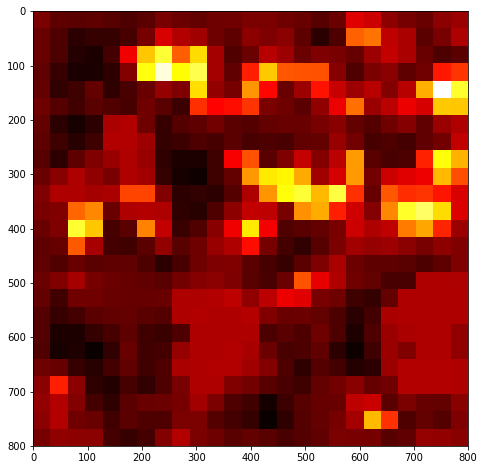

In [53]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 8, 8

plt.imshow(heat.cpu().numpy().[0,1], cmap='hot', interpolation='nearest')
plt.show()

In [75]:
heat[1]

IndexError: index 1 is out of range for dimension 0 (of size 1)